# Route Art: Generative Visualizations
This notebook explores artistic ways to visualize a large collection of activity routes (1,000+). Instead of a grid, we look at overlays, chronological fingerprints, and mathematical arrangements.

In [10]:
import pandas as pd
import polyline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.collections as mcoll
from sklearn.cluster import KMeans

## 1. Load and Preprocess Data

In [11]:
def load_data(path="../data/processed/activities.parquet"):
    df = pd.read_parquet(path)
    df = df[df['map_polyline'].notna() & (df['map_polyline'] != "")]
    df['start_date'] = pd.to_datetime(df['start_date'])
    df = df.sort_values('start_date', ascending=True) # Oldest to newest for DNA strip
    return df

def decode_and_center(polyline_str):
    try:
        coords = polyline.decode(polyline_str)
        if not coords: return None
        coords = np.array(coords)
        # Center at origin (0,0)
        centroid = coords.mean(axis=0)
        centered = coords - centroid
        # Scale to max dimension of 1.0
        max_dim = np.abs(centered).max()
        if max_dim == 0: return centered
        return centered / max_dim
    except:
        return None

df = load_data()
print(f"Processing shapes for {len(df)} activities...")
all_shapes = [decode_and_center(p) for p in df['map_polyline']]
all_shapes = [s for s in all_shapes if s is not None]

Processing shapes for 2089 activities...


## 2. The Route Bloom
An overlay of every single route shape, centered at (0,0) with high transparency. This creates a statistical silhouette of your movement.

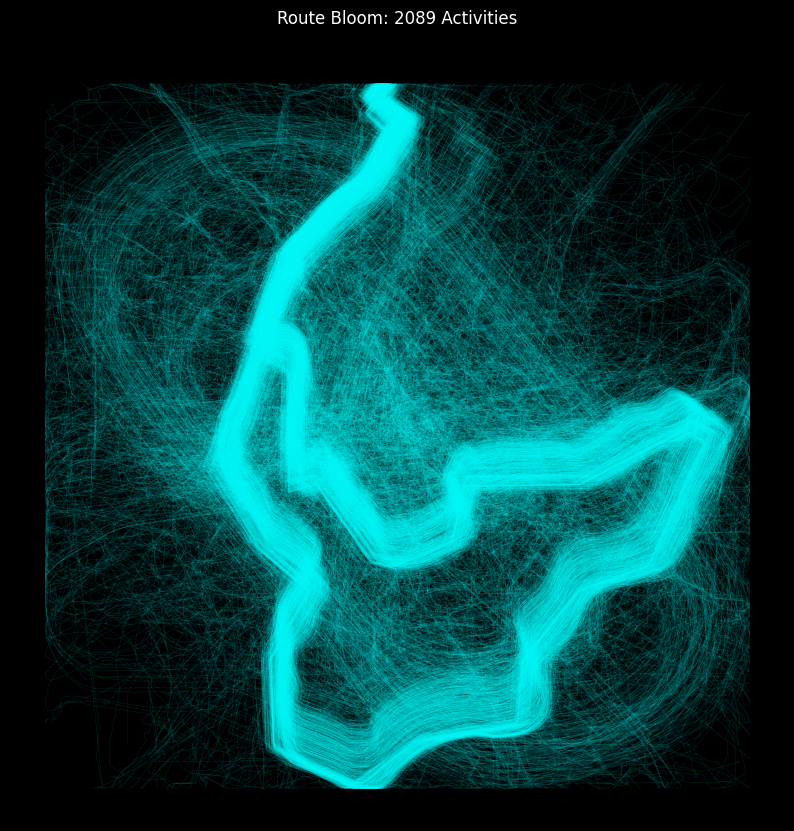

In [12]:
def plot_bloom(shapes, color='#1f77b4', alpha=0.01):
    plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    for s in shapes:
        # Swap lat/lon for plot x/y
        plt.plot(s[:, 1], s[:, 0], color=color, alpha=alpha, linewidth=0.5)
    
    plt.axis('equal')
    plt.axis('off')
    plt.title(f"Route Bloom: {len(shapes)} Activities", color='white', pad=20)
    plt.show()

plot_bloom(all_shapes, color='cyan', alpha=0.1)

## 3. The DNA Strand
Every route plotted side-by-side in chronological order. This creates a vertical "fingerprint" of your athletic life.

In [ ]:
def plot_dna_strand(shapes, limit=100):
    subset = shapes[:limit]
    count = len(subset)
    
    # Each route occupies a unit space on the X axis
    plt.figure(figsize=(15, 6))
    for i, s in enumerate(subset):
        # Offset x by i*2 to space them out
        plt.plot(s[:, 1] + i*1.2, s[:, 0], color='#2c3e50', linewidth=0.2, alpha=0.7)
    
    plt.axis('equal')
    plt.axis('off')
    plt.title(f"DNA Strand: First {limit} Activities", loc='left')
    plt.tight_layout()
    plt.show()

plot_dna_strand(all_shapes)

## 4. The Time Spiral
Arranging activity shapes along an Archimedean spiral. This visualizes growth and density over time.

In [ ]:
def plot_spiral(shapes, spacing=1.5):
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    
    for i, s in enumerate(shapes):
        # Archimedean spiral: r = a + b*theta
        theta = 0.5 * np.sqrt(i * 15) 
        r = theta * spacing
        
        cx = r * np.cos(theta)
        cy = r * np.sin(theta)
        
        # Mini-shape size scaling
        scale = 0.5
        plt.plot(s[:, 1]*scale + cx, s[:, 0]*scale + cy, color='black', linewidth=0.3, alpha=0.6)
        
    plt.axis('equal')
    plt.axis('off')
    plt.title("The Time Spiral")
    plt.show()

plot_spiral(all_shapes)

## 5. Similarity Clusters

Resampling shapes for clustering...
Clustering into 20 similarity groups...


/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/enanale/Code/stravagraph/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invali

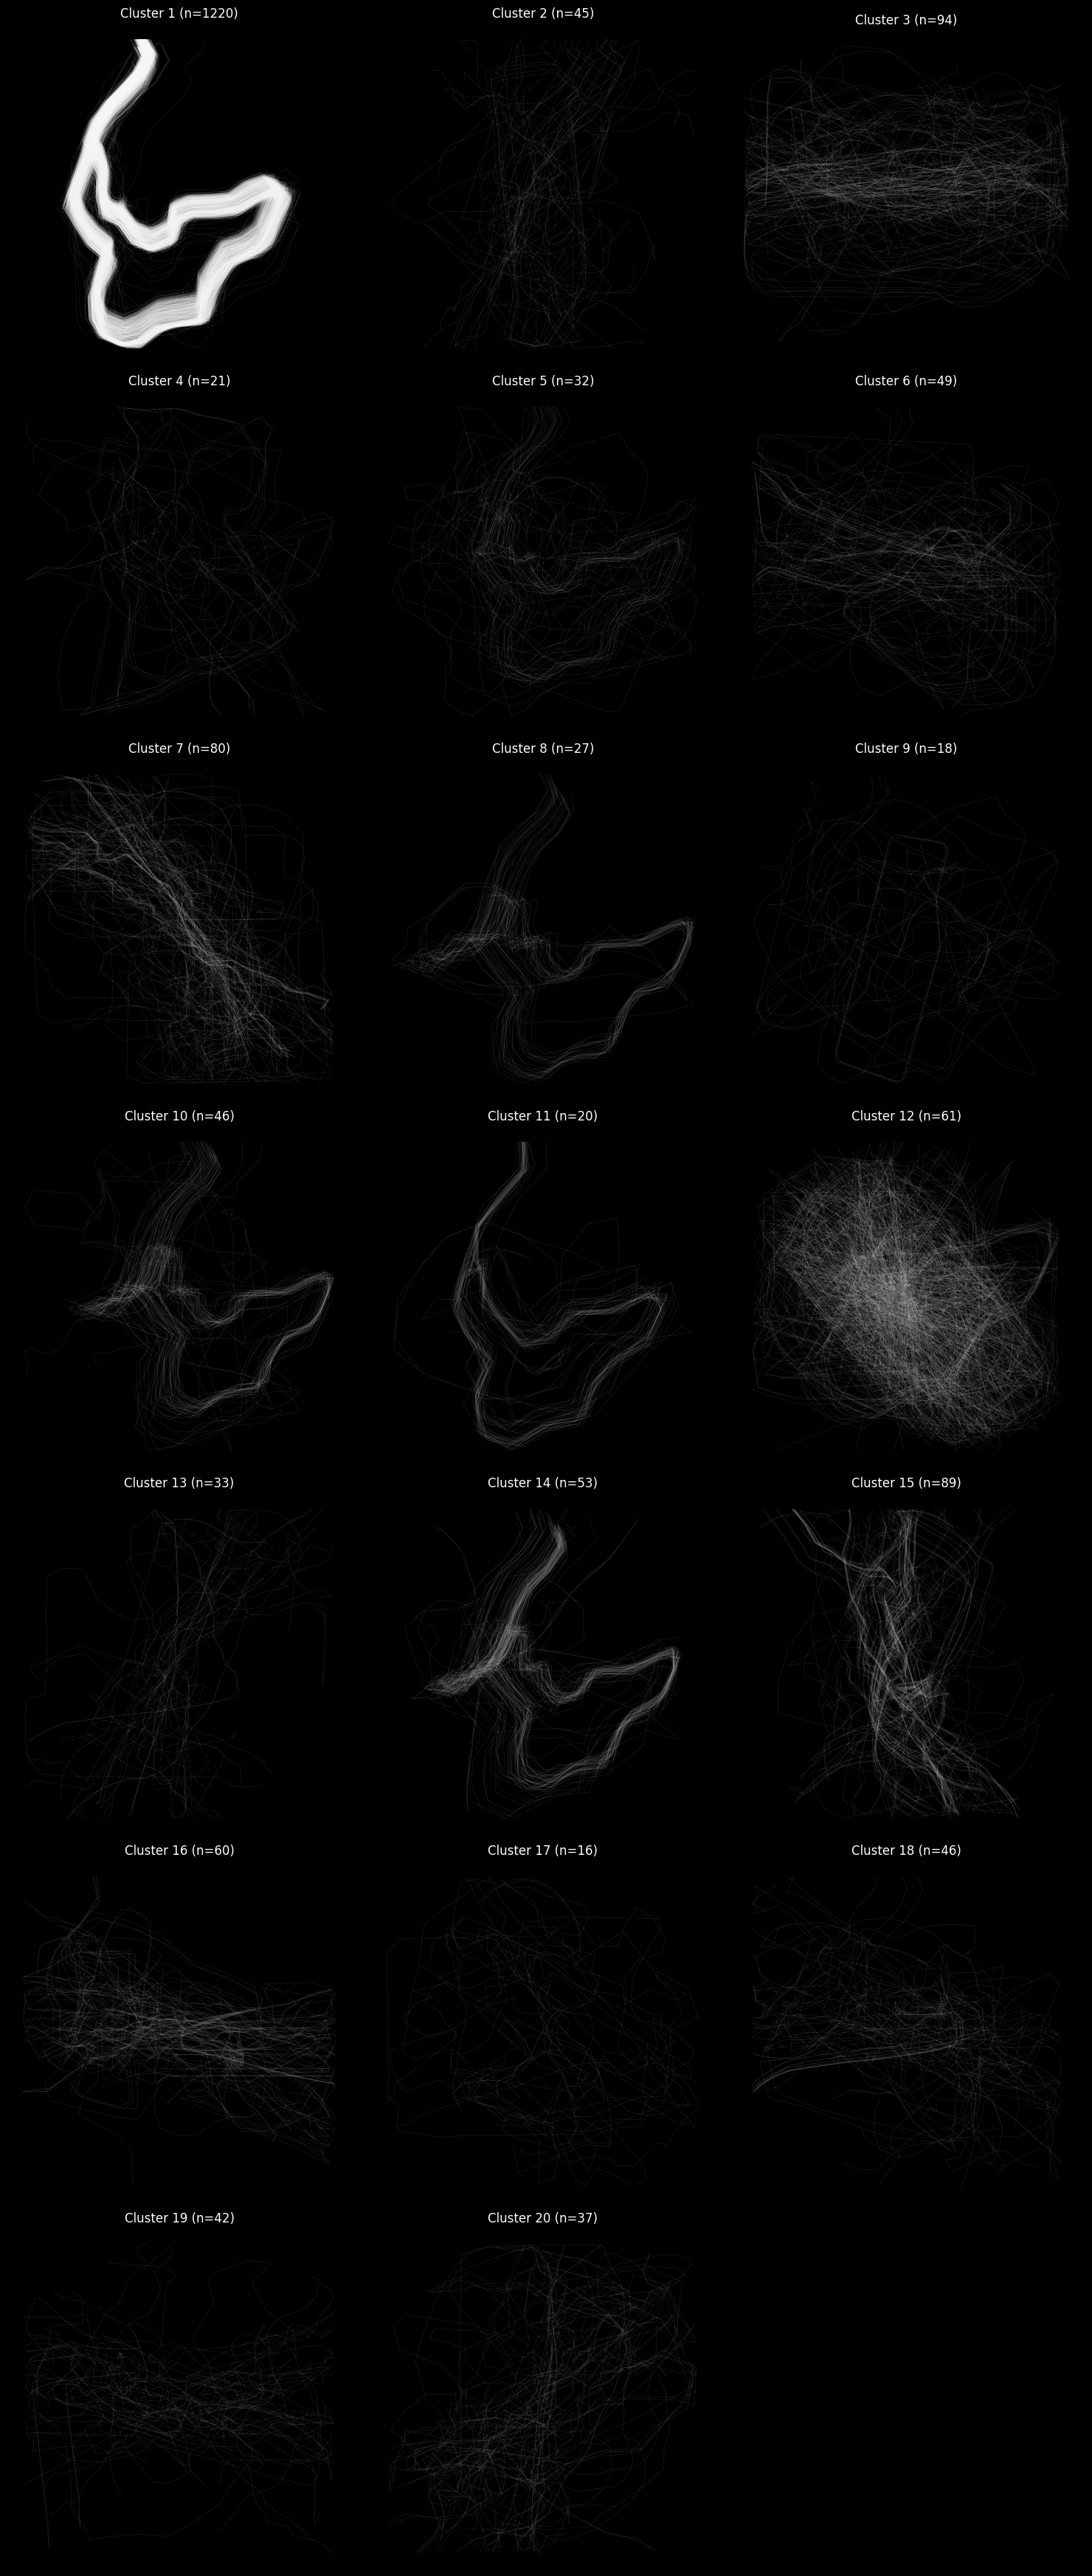

In [14]:
def resample_shape(shape, n_points=50):
    if shape is None or len(shape) < 2: return None
    dist = np.sqrt(np.diff(shape[:, 0])**2 + np.diff(shape[:, 1])**2)
    cum_dist = np.concatenate(([0], np.cumsum(dist)))
    total_dist = cum_dist[-1]
    if total_dist == 0: return np.zeros((n_points, 2))
    target_dist = np.linspace(0, total_dist, n_points)
    new_x = np.interp(target_dist, cum_dist, shape[:, 0])
    new_y = np.interp(target_dist, cum_dist, shape[:, 1])
    return np.column_stack((new_x, new_y))

print("Resampling shapes for clustering...")
resampled = [resample_shape(s) for s in all_shapes]
resampled = [r for r in resampled if r is not None]
X = np.array([r.flatten() for r in resampled])
n_clusters = 20
print(f"Clustering into {n_clusters} similarity groups...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

def plot_clusters(resampled, labels, n_clusters):
    n_cols = 3
    n_rows = (n_clusters + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), facecolor='black')
    axes = axes.flatten()
    for i in range(n_clusters):
        ax = axes[i]
        cluster_shapes = [resampled[j] for j in range(len(resampled)) if labels[j] == i]
        for s in cluster_shapes:
            ax.plot(s[:, 1], s[:, 0], color='white', alpha=0.1, lw=0.5)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f"Cluster {i+1} (n={len(cluster_shapes)})", color='white', fontsize=12)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

plot_clusters(resampled, labels, n_clusters)